# Personal Financial Assistant

## Objective

This notebook demonstrates the following:

- Function Calling with Yfinance to get latest stock prices. Summarization of user provided article. Extract country info from article, extract country, capital and other aspects, and call an API to get more information about each country.

This tutorial uses the following Azure AI services:
- Access to Azure OpenAI Service - you can apply for access [here](https://aka.ms/oai/access)
- Azure OpenAI service - you can create it from instructions [here](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/create-resource)
- Azure OpenAI Studio - go to [https://oai.azure.com/](https://oai.azure.com/) to work with the Assistants API Playground
- A connection to the Azure OpenAI Service with a [Key and Endpoint](https://learn.microsoft.com/en-us/azure/ai-services/openai/chatgpt-quickstart)

Reference:
- Learn more about how to use Assistants with our [How-to guide on Assistants](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/assistant)
- [Assistants OpenAI Overview](https://platform.openai.com/docs/assistants/overview)

## Time

You should expect to spend 10-15 minutes running this sample. 

## About this example

The objective of the provided Python file is to create an Azure OpenAI Assistant named "Portfolio Management Assistant" using the Azure OpenAI API. The assistant is designed to act as a personal financial assistant, providing information and insights related to a user's investment portfolio. The script initiates a conversation with the assistant, guiding it through various financial queries and scenarios to showcase its capabilities.

### Data
This sample uses files from the folder [`data/`](./data/) in this repo. You can clone this repo or copy this folder to make sure you have access to these files when running the sample.



### Parameters

In [1]:
import os

from dotenv import load_dotenv

load_dotenv()
api_endpoint = os.getenv("OPENAI_URI")
api_key = os.getenv("OPENAI_KEY")
api_version = os.getenv("OPENAI_VERSION")
api_deployment_name = os.getenv("OPENAI_GPT_DEPLOYMENT")
email_URI = os.getenv("EMAIL_URI")

should_cleanup: bool = False

## Run this Example

### Load the required libraries

In [2]:
import html
import io
import time
from datetime import datetime
from pathlib import Path
from typing import Iterable 
from PIL import Image
import matplotlib.pyplot as plt 

import requests
import yfinance as yf
from openai import AzureOpenAI
from openai.types import FileObject
from openai.types.beta import Thread
from openai.types.beta.threads import Run
from openai.types.beta.threads.message_content_image_file import MessageContentImageFile
from openai.types.beta.threads.message_content_text import MessageContentText
from openai.types.beta.threads.messages import MessageFile


### Create an AzureOpenAI client

In [3]:
client = AzureOpenAI(api_key=api_key, api_version=api_version, azure_endpoint=api_endpoint)

### Get the latest stock price by ticker symbol using Yahoo Finance

In [4]:
def get_stock_price(symbol: str) -> float:
    stock = yf.Ticker(symbol)
    return stock.history(period="1d")["Close"].iloc[-1]

### Send an email using Logic Apps

In [5]:
def send_logic_apps_email(to: str, content: str) -> None:
    json_payload = {"to": to, "content": html.unescape(content)}
    headers = {"Content-Type": "application/json"}
    response = requests.post(email_URI, json=json_payload, headers=headers)
    if response.status_code == 202:
        print("Email sent to: " + json_payload["to"])

### Define the Assistant tools

In [6]:
tools_list = [
    {"type": "code_interpreter"},
    {
        "type": "function",
        "function": {
            "name": "get_stock_price",
            "description": "Retrieve the latest closing price of a stock using its ticker symbol.",
            "parameters": {
                "type": "object",
                "properties": {"symbol": {"type": "string", "description": "The ticker symbol of the stock"}},
                "required": ["symbol"],
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "send_email",
            "description": "Sends an email to a recipient(s).",
            "parameters": {
                "type": "object",
                "properties": {
                    "to": {"type": "string", "description": "The email(s) the email should be sent to."},
                    "content": {"type": "string", "description": "The content of the email."},
                },
                "required": ["to", "content"],
            },
        },
    },
]

### Upload the file(s)

In [7]:

DATA_FOLDER = "data/"
TARGET_FILE = "portfolio.csv"

def upload_file(client: AzureOpenAI, path: str) -> FileObject:
    with Path(path).open("rb") as f:
        return client.files.create(file=f, purpose="assistants")

# 파일명으로 검색하여 파일이 존재하는지 확인
filePath = os.path.join(DATA_FOLDER, TARGET_FILE)
assistant_files = []

if os.path.exists(filePath):
    assistant_files.append(upload_file(client, filePath))

file_ids = [file.id for file in assistant_files]

print(file_ids)


['assistant-eohmyE8K7TnLKov4fzeZNpEh']


### Create an Assistant and a Thread

In [8]:
assistant = client.beta.assistants.create(
    name="Portfolio Management Assistant",
    instructions="You are a personal securities trading assistant. Please be polite, professional, helpful, and friendly. "
    + "Use the provided portfolio CSV file to answer the questions. If question is not related to the portfolio or you cannot answer the question, say, 'contact a representative for more assistance.'"
    + "If the user asks for help or says 'help', provide a list of sample questions that you can answer.",
    tools=tools_list,
    model=api_deployment_name,
    file_ids=file_ids,
)

thread = client.beta.threads.create()

### Process Function calling

In [9]:
def call_functions(client: AzureOpenAI, thread: Thread, run: Run) -> None:
    print("Function Calling")
    required_actions = run.required_action.submit_tool_outputs.model_dump()
    print(required_actions)
    tool_outputs = []
    import json

    for action in required_actions["tool_calls"]:
        func_name = action["function"]["name"]
        arguments = json.loads(action["function"]["arguments"])

        if func_name == "get_stock_price":
            output = get_stock_price(symbol=arguments["symbol"])
            # tool_outputs.append({"tool_call_id": action["id"], "output": output})
            tool_outputs.append({"tool_call_id": action["id"], "output": str(output)})  # 소수를 문자열로 변환

        elif func_name == "send_email":
            print("Sending email...")
            email_to = arguments["to"]
            email_content = arguments["content"]
            send_logic_apps_email(email_to, email_content)

            tool_outputs.append({"tool_call_id": action["id"], "output": "Email sent"})
        else:
            raise ValueError(f"Unknown function: {func_name}")

    print("Submitting outputs back to the Assistant...")
    client.beta.threads.runs.submit_tool_outputs(thread_id=thread.id, run_id=run.id, tool_outputs=tool_outputs)

### Format and display the Assistant Messages for text and images

In [10]:
 

def format_messages(messages: Iterable[MessageFile]) -> None:
    message_list = []

    # Get all the messages till the last user message
    for message in messages:
        message_list.append(message)
        if message.role == "user":
            break

    # Reverse the messages to show the last user message first
    message_list.reverse()

    # Print the user or Assistant messages or images
    for message in message_list:
        for item in message.content:
            # Determine the content type
            if isinstance(item, MessageContentText):
                print(f"{message.role}:\n{item.text.value}\n")
            elif isinstance(item, MessageContentImageFile):
                # Retrieve image from file id
                response_content = client.files.content(item.image_file.file_id)
                data_in_bytes = response_content.read()
                # Convert bytes to image
                readable_buffer = io.BytesIO(data_in_bytes)
                image = Image.open(readable_buffer)
                # Resize image to fit in terminal
                width, height = image.size
                image = image.resize((width // 2, height // 2), Image.LANCZOS)
                # Display image using matplotlib
                plt.imshow(image)
                plt.axis('off')  # Hide axis
                plt.show()


### Process the user messages

In [11]:
def process_message(content: str) -> None:
    client.beta.threads.messages.create(thread_id=thread.id, role="user", content=content)

    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
        instructions="The current date and time is: " + datetime.now().strftime("%x %X") + ".",
    )

    print("processing...")
    while True:
        run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
        if run.status == "completed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)             
            break
        if run.status == "failed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            # Handle failed
            break
        if run.status == "expired":
            # Handle expired
            break
        if run.status == "cancelled":
            # Handle cancelled
            break
        if run.status == "requires_action":
            call_functions(client, thread, run)
        else:
            time.sleep(5)

### Have a conversation with the Assistant

In [12]:
process_message("Based on the provided portfolio, what investments do I own?")

processing...
user:
Based on the provided portfolio, what investments do I own?

assistant:
Let's start by examining the contents of the uploaded file to understand what investments you own. I will read the contents of the file and extract the relevant information.

assistant:
It appears there was an issue determining the format of the file. If this file is not in Excel format, I will try reading it as a CSV file. Let's attempt to read the file in a different format.

assistant:
The file contains the following columns: `Symbol`, `Average_Cost`, and `QTY`. 

Based on this information, here are the investments you own:

1. Microsoft (MSFT) - 300 shares at an average cost of $200 each
2. Apple (AAPL) - 200 shares at an average cost of $114 each
3. Amazon (AMZN) - 50 shares at an average cost of $125 each
4. Tesla (TSLA) - 100 shares at an average cost of $900 each
5. Netflix (NFLX) - 80 shares at an average cost of $540 each

If you need any further analysis or information regarding these

In [13]:
process_message("What is the value of my portfolio?")

processing...
Function Calling
{'tool_calls': [{'id': 'call_es3OWeX83cFJnlwXnxoLNeK9', 'function': {'arguments': '{"symbol": "MSFT"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_u6dEEtbK5VogDuWJXvcwQoKx', 'function': {'arguments': '{"symbol": "AAPL"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_Uz6PQUUVo1jRVG1mj8i6NobJ', 'function': {'arguments': '{"symbol": "AMZN"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_isyHk20ilQyf9USHsuAhQIlQ', 'function': {'arguments': '{"symbol": "TSLA"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_UlnfNMe2NwJM0oKKzEaZq8Pp', 'function': {'arguments': '{"symbol": "NFLX"}', 'name': 'get_stock_price'}, 'type': 'function'}]}
Submitting outputs back to the Assistant...
user:
What is the value of my portfolio?

assistant:
To compute the value of your portfolio, we need to obtain the current prices of the stocks you own. After that, we can calculate the value of each investment by multiplyi

In [14]:
process_message("What is my best and worst investment?")

processing...
user:
What is my best and worst investment?

assistant:
To determine your best and worst investments, we can analyze the current total value and the cost basis for each investment. We'll compare the gains/losses for each stock by calculating the difference between the current value and the initial investment (average cost times quantity).

Let's calculate the gain or loss for each investment to identify the best and worst investments.

assistant:
Based on the gain or loss calculations, here are your best and worst investments:

- **Best Investment:**
  - **Microsoft (MSFT)**
    - Initial Investment: \$60,000
    - Current Value: \$134,856.00
    - Gain: \$74,856.00

- **Worst Investment:**
  - **Tesla (TSLA)**
    - Initial Investment: \$90,000
    - Current Value: \$25,656.00
    - Loss: -\$64,344.00

If you need more detailed analysis or further assistance, please let me know!



processing...
user:
Chart the realized gain or loss of my investments.



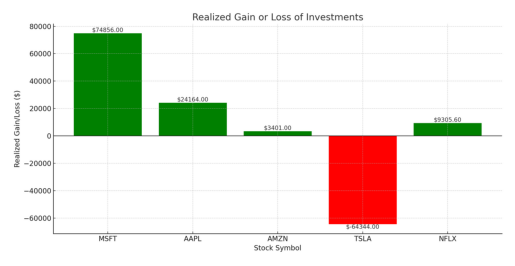

assistant:
Here is the chart representing the realized gain or loss for each of your investments:

- Green bars indicate a gain.
- Red bars indicate a loss.

As we can see, Microsoft (MSFT) is your best investment with the highest gain, while Tesla (TSLA) is your worst investment with the largest loss.

If you have any further questions or need additional analysis, please let me know!



In [15]:
process_message("Chart the realized gain or loss of my investments.")

In [16]:
process_message(
    "Please send a report to daeungo@microsoft.com with the details for each stock based on the latest stock prices, and list the best and worst performing stocks in my portfolio."
)

processing...
Function Calling
{'tool_calls': [{'id': 'call_crJwgyVipFIlPwOLWTkaR3bo', 'function': {'arguments': '{"to":"daeungo@microsoft.com","content":"Dear Daeungo,\\n\\nPlease find below the detailed report for each stock in your portfolio based on the latest stock prices:\\n\\n1. Microsoft (MSFT)\\n   - Quantity: 300 shares\\n   - Average Cost: $200\\n   - Current Price: $449.52\\n   - Current Value: $134,856.00\\n   - Initial Investment: $60,000\\n   - Gain: $74,856.00\\n\\n2. Apple (AAPL)\\n   - Quantity: 200 shares\\n   - Average Cost: $114\\n   - Current Price: $234.82\\n   - Current Value: $46,964.00\\n   - Initial Investment: $22,800\\n   - Gain: $24,164.00\\n\\n3. Amazon (AMZN)\\n   - Quantity: 50 shares\\n   - Average Cost: $125\\n   - Current Price: $193.02\\n   - Current Value: $9,651.00\\n   - Initial Investment: $6,250\\n   - Gain: $3,401.00\\n\\n4. Tesla (TSLA)\\n   - Quantity: 100 shares\\n   - Average Cost: $900\\n   - Current Price: $256.56\\n   - Current Value: $

## Cleaning up

In [17]:
if should_cleanup:
    client.beta.assistants.delete(assistant.id)
    client.beta.threads.delete(thread.id)
    for file in assistant_files:
        client.files.delete(file.id)